In [105]:
pwd

'/Users/aidasaglinskas/Desktop/BC-FacExpr-1.2-fMRI-mainExp'

In [106]:
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance,ImageStat
import skvideo
import skvideo.io
import numpy as np
import os
from tqdm import tqdm

In [107]:
def load_video(fn):
    import skvideo
    videodata = skvideo.io.vread(fn)
    return videodata

In [108]:
indir = './stimuli_normed_cb/'
files = [os.path.join(indir,file) for file in os.listdir(indir) if file.endswith('.mp4')]
files.sort()
files[0:5]

['./stimuli_normed_cb/id1d1.mp4',
 './stimuli_normed_cb/id1d2.mp4',
 './stimuli_normed_cb/id1f1.mp4',
 './stimuli_normed_cb/id1f2.mp4',
 './stimuli_normed_cb/id1h1.mp4']

In [109]:
len(files)

70

100%|███████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


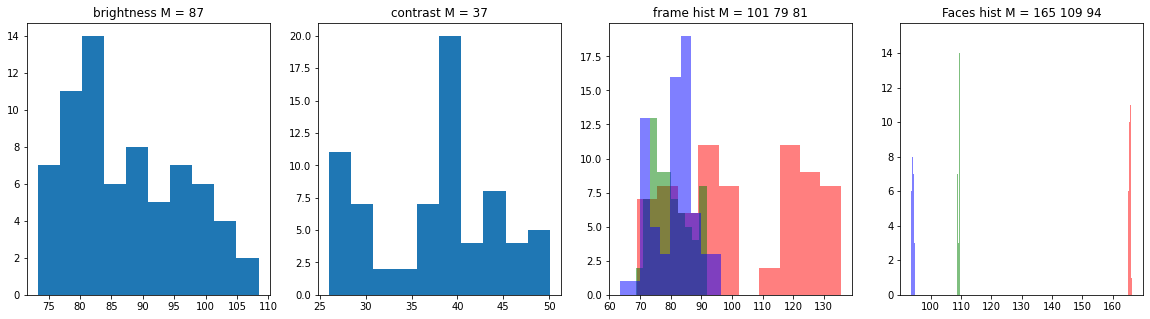

In [110]:
##### CALCULATE

hist_brightness = []
hist_contrast = []
hist_r = []
hist_g = []
hist_b = []
for file in tqdm(files):
    vid = load_video(file)
    
    hist_brightness.append(  vid[0,:,:,:].mean()  )
    hist_contrast.append(  vid[0,:,:,:].mean(axis=-1).std() )
    
    hist_r.append( vid[:,:,:,0].mean() )
    hist_g.append( vid[:,:,:,1].mean() )
    hist_b.append( vid[:,:,:,2].mean() )
    
    
l = 50
face_squares = np.array([load_video(files[i])[0,:,:,:][256-l:256+l,256-l:256+l,:] for i in tqdm(range(len(files))) ])

##### PLOT

brightness_target = np.array(hist_brightness).mean().round(3)

contrast_target = np.array(hist_contrast).mean().round(3)

target_r = np.array(hist_r).mean().round(3)
target_g = np.array(hist_g).mean().round(3)
target_b = np.array(hist_b).mean().round(3)

ctargets = face_squares.mean(axis=0).mean(axis=0).mean(axis=0)
ctargets


plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.hist(hist_brightness);
plt.title(f'brightness M = {brightness_target.astype(int)}');
plt.subplot(1,4,2)
plt.hist(hist_contrast);
plt.title(f'contrast M = {contrast_target.astype(int)}');
plt.subplot(1,4,3)
plt.hist(hist_r,color='r',alpha=.5);
plt.hist(hist_g,color='g',alpha=.5);
plt.hist(hist_b,color='b',alpha=.5);
plt.title(f'frame hist M = {target_r.astype(int)} {target_g.astype(int)} {target_b.astype(int)}');

plt.subplot(1,4,4)
plt.hist( face_squares.mean(axis=1).mean(axis=1)[:,0],color='r',alpha=.5)
plt.hist( face_squares.mean(axis=1).mean(axis=1)[:,1],color='g',alpha=.5)
plt.hist( face_squares.mean(axis=1).mean(axis=1)[:,2],color='b',alpha=.5)
plt.title(f'Faces hist M = {ctargets[0].astype(int)} {ctargets[1].astype(int)} {ctargets[2].astype(int)}');

In [111]:
def brighten_video(videodata,factor=1):
    return np.array([np.array(ImageEnhance.Brightness(Image.fromarray(videodata[frame,:,:,:])).enhance(factor)) for frame in range(videodata.shape[0])])

In [112]:
def contrast_video(videodata,factor=1):
    return np.array([np.array(ImageEnhance.Contrast(Image.fromarray(videodata[frame,:,:,:])).enhance(factor)) for frame in range(videodata.shape[0])])

In [113]:
def save_video(videodata,ofn='outvideo.mp4'):
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})

In [114]:
def make_ref(ctargets):
    ref = np.ones((10,10,3))
    for i in range(3):
        ref[:,:,i] = ref[:,:,i] * ctargets[i]
    return ref.astype(np.uint8)

In [115]:
def get_face(frame,l=50):
    return frame[256-l:256+l,256-l:256+l,:]

In [116]:
def get_mean_rbg(frame):
    return frame.mean(axis=0).mean(axis=0)

In [117]:
def tint_frame_face(frame,ctargets):
    
    face_square = get_face(frame)
    diff = get_mean_rbg(face_square)-ctargets
    frame_copy = frame.astype(np.float64)
    for i in range(3):
        frame_copy[:,:,i] = frame_copy[:,:,i] - diff[i]
        frame_copy[frame_copy<0]=0
        frame_copy[frame_copy>255]=255
        
    frame_copy = frame_copy.astype(np.uint8)
    return frame_copy

In [118]:
def tint_video_face(videodata,ctargets):
    nframes = videodata.shape[0]
    tinted_video = np.array([tint_frame_face(videodata[i,:,:,:],ctargets) for i in range(nframes)])
    return tinted_video

In [119]:
# contrast_target = 50
# brightness_target = 75
# for i in range(25):
#     contrast = get_face(videodata[0,:,:,:]).mean(axis=-1).std()
#     brightness = get_face(videodata[0,:,:,:]).mean()

#     videodata = contrast_video(videodata,contrast_target/contrast)
#     videodata = brighten_video(videodata,brightness_target/brightness)

In [120]:
face_squares.mean(axis=0).mean(axis=0).mean(axis=0)

array([165.61743   , 109.19266143,  94.23938143])

In [121]:
ctargets = face_squares[0:10].mean(axis=0).mean(axis=0).mean(axis=0)
ctargets

array([165.65472, 109.3102 ,  94.28742])

In [84]:
ctargets = np.array([125,100,100])

In [86]:
ofdir = './stimuli_normed_cb_tint/'

#for f in np.arange(0,70,10):
for f in tqdm(range(len(files))):
    fn = files[f]
    videodata = load_video(fn)
    frame = videodata[0,:,:,:]
    face_square = get_face(frame)
    face_ref = make_ref(get_mean_rbg(face_square))
    
    
    frame_copy = tint_frame_face(frame,ctargets)
    tinted_video = tint_video_face(videodata,ctargets)
    frame_copy = tinted_video[0,:,:,:]
    save_video(tinted_video,fn.replace(indir,ofdir))

    
    new_face = get_face(frame_copy)
    new_face_ref = make_ref(get_mean_rbg(new_face))
    
    do_plot = False
    if do_plot:
        ncols = 7
        plt.figure(figsize=(5*ncols,ncols));i=0;
        i+=1;plt.subplot(1,ncols,i);plt.imshow(frame);plt.xticks([]);plt.yticks([]);plt.title('Orig Frame');
        i+=1;plt.subplot(1,ncols,i);plt.imshow(frame_copy);plt.xticks([]);plt.yticks([]);plt.title('new frame');

        i+=1;plt.subplot(1,ncols,i);plt.imshow(face_square);plt.xticks([]);plt.yticks([]);plt.title('Orig Face');
        i+=1;plt.subplot(1,ncols,i);plt.imshow(new_face);plt.xticks([]);plt.yticks([]);plt.title('New Face');

        i+=1;plt.subplot(1,ncols,i);plt.imshow(face_ref);plt.xticks([]);plt.yticks([]);plt.title('Orig Face mean');
        i+=1;plt.subplot(1,ncols,i);plt.imshow(new_face_ref);plt.xticks([]);plt.yticks([]);plt.title('New Face mean');
        i+=1;plt.subplot(1,ncols,i);plt.imshow(make_ref(ctargets));plt.xticks([]);plt.yticks([]);plt.title('Target mean');

100%|███████████████████████████████████████████| 70/70 [01:16<00:00,  1.09s/it]


100%|███████████████████████████████████████████| 70/70 [00:10<00:00,  6.81it/s]


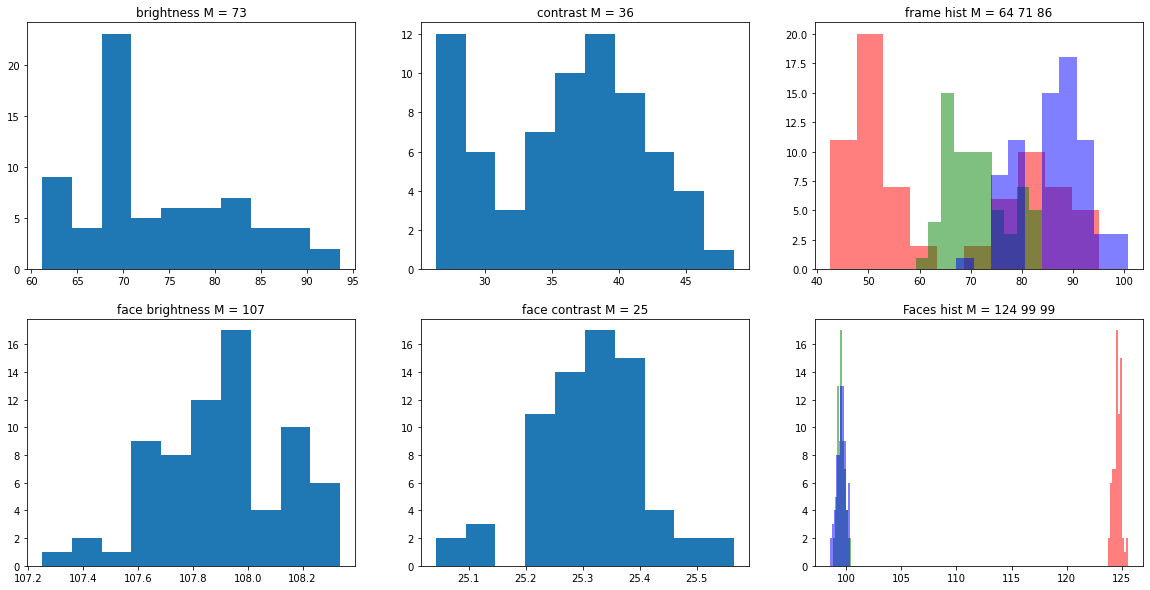

In [87]:
#### DEFINE 

indir = './stimuli_normed_cb_tint/'
files = [os.path.join(indir,file) for file in os.listdir(indir) if file.endswith('.mp4')]
files.sort()
files[0:5]

##### CALCULATE

hist_brightness = []
hist_contrast = []
hist_r = []
hist_g = []
hist_b = []
for file in tqdm(files):
    vid = load_video(file)
    
    hist_brightness.append(  vid[0,:,:,:].mean()  )
    hist_contrast.append(  vid[0,:,:,:].mean(axis=-1).std() )
    
    hist_r.append( vid[:,:,:,0].mean() )
    hist_g.append( vid[:,:,:,1].mean() )
    hist_b.append( vid[:,:,:,2].mean() )
    
    
l = 50
face_squares = np.array([load_video(files[i])[0,:,:,:][256-l:256+l,256-l:256+l,:] for i in tqdm(range(len(files))) ])

##### PLOT

brightness_target = np.array(hist_brightness).mean().round(3)

contrast_target = np.array(hist_contrast).mean().round(3)

target_r = np.array(hist_r).mean().round(3)
target_g = np.array(hist_g).mean().round(3)
target_b = np.array(hist_b).mean().round(3)

ctargets = face_squares.mean(axis=0).mean(axis=0).mean(axis=0)
ctargets


plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.hist(hist_brightness);
plt.title(f'brightness M = {brightness_target.astype(int)}');
plt.subplot(2,3,2)
plt.hist(hist_contrast);
plt.title(f'contrast M = {contrast_target.astype(int)}');
plt.subplot(2,3,3)
plt.hist(hist_r,color='r',alpha=.5);
plt.hist(hist_g,color='g',alpha=.5);
plt.hist(hist_b,color='b',alpha=.5);
plt.title(f'frame hist M = {target_r.astype(int)} {target_g.astype(int)} {target_b.astype(int)}');


plt.subplot(2,3,4)
face_brightness = np.array([face_squares[i,:,:,:].mean() for i in range(face_squares.shape[0])])
plt.hist(face_brightness)
plt.title(f'face brightness M = {face_brightness.mean().astype(int)}');

plt.subplot(2,3,5)
face_contrast = np.array([face_squares[i,:,:,:].mean(axis=-1).std() for i in range(face_squares.shape[0])])
plt.hist(face_contrast)
plt.title(f'face contrast M = {face_contrast.mean().astype(int)}');


plt.subplot(2,3,6)
plt.hist( face_squares.mean(axis=1).mean(axis=1)[:,0],color='r',alpha=.5)
plt.hist( face_squares.mean(axis=1).mean(axis=1)[:,1],color='g',alpha=.5)
plt.hist( face_squares.mean(axis=1).mean(axis=1)[:,2],color='b',alpha=.5)
plt.title(f'Faces hist M = {ctargets[0].astype(int)} {ctargets[1].astype(int)} {ctargets[2].astype(int)}');